In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base= automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [8]:
# inspect data types
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

c:\Users\Kevin\anaconda3\envs\bootcamp\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


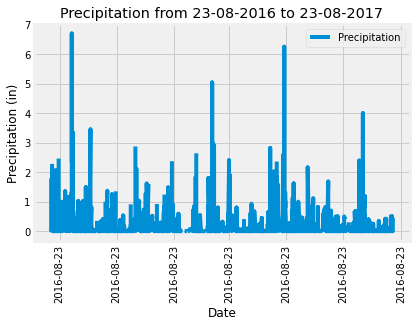

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date#2017-08-23

# Calculate the date 1 year ago from the last data point in the database
limit_date = dt.date(2017, 8, 23)- dt.timedelta(days=365)
limit_date #2016-08-23

# Perform a query to retrieve the data and precipitation scores
data = session.query(measurement.date, measurement.prcp).filter(measurement.date>=limit_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df= pd.DataFrame(data, columns=['date','prcp'])
data_df['date']= pd.to_datetime(data_df['date'])
data_df['date']=data_df['date'].dt.date
data_df = data_df.set_index('date')

# Sort the dataframe by date
prcp = data_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
date = prcp.index
prcps = prcp['prcp']

fig, ax = plt.subplots()
ax.plot(date, prcps, label = 'Precipitation')
ax.legend(fontsize = 10)
ax.set_xticklabels(date,rotation =90)

# labels for title and axes
ax.set_title('Precipitation from 23-08-2016 to 23-08-2017')
ax.set_ylabel('Precipitation (in)')
ax.set_xlabel('Date')

plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_stats= prcp.describe()
prcp_stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(station.station).count()


9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
sel = measurement.station,func.count(measurement.id)

activity = session.query(*sel).group_by(measurement.station).\
                order_by(measurement.id.desc()).all()

# List the stations and the counts in descending order.
activity_df= pd.DataFrame(activity)
activity_df.sort_values(by=[1],ascending=False)


,0,1
2,USC00519281,2772
8,USC00519397,2724
7,USC00513117,2709
3,USC00519523,2669
0,USC00516128,2612
6,USC00514830,2202
1,USC00511918,1979
5,USC00517948,1372
4,USC00518838,511


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
max =engine.execute('SELECT * FROM measurement GROUP BY station ORDER BY tobs').first()
max

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)

In [16]:
# highest temperature recorded, and average temperature of the most active station?
sel = [measurement.station,
    func.count(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)]

most_active = session.query(*sel).\
            group_by(measurement.station).\
            order_by(func.count(measurement.id).desc()).first()
            
most_active

('USC00519281', 2772, 85.0, 71.66378066378067)

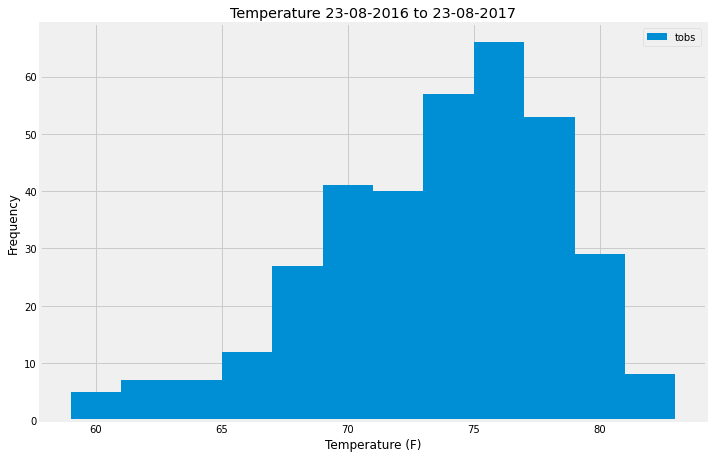

In [17]:
# Choose the station with the highest number of temperature observations
# # Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= limit_date).all()
temps
# create data frame
temps_df = pd.DataFrame(temps, columns = ['tobs'])
temps_df
# # tempplot= temps_df.iloc[:,[0,2]]
# # tempplot

# # create the plot
plt.figure(figsize=(10,6))
plt.hist(temps_df['tobs'], bins=12)
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.tight_layout()

# labels for title and axes
plt.title(f'Temperature 23-08-2016 to 23-08-2017')
plt.xlabel('Temperature (F)') 

plt.show()




## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax

temps_stats= calc_temps('2016-08-23', '2017-08-23')

stats= pd.DataFrame(temps_stats)

# for your trip using the previous year's data for those same dates.

tmin = stats[0]
tave = stats[1]
tmax = stats[2]



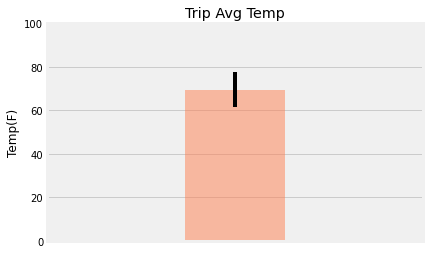

<Figure size 432x288 with 0 Axes>

In [81]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax - tmin

plt.bar(1, height = 69.57, yerr = 8, align='center', color="coral", alpha = 0.5)


plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.ylim(0, 100)
plt.xlim(-0.5,2.5)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')

plt.figure()
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
